In [3]:
%run ~/relmapping/annot/notebooks/__init__.ipynb
def vp(fp): return os.path.join('annot/Fig2S3_tss/', fp) # "verbose path"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
os.getcwd(): /mnt/beegfs/scratch_copy/ahringer/jj374/lab/relmapping


In [4]:
# (Chen et al., 2013) TSSs -- load
def WS260_geneIDs():
    fp_geneIDs = lp('.wget/ftp.wormbase.org/pub/wormbase/releases/WS260/species/c_elegans/PRJNA13758/annotation/c_elegans.PRJNA13758.WS260.geneIDs.txt.gz')
    df_geneIDs = pd.read_csv(fp_geneIDs, sep=',', names=('na', 'gene_id', 'locus', 'sequence_id', 'status'))\
        [['gene_id', 'locus', 'sequence_id', 'status']]
    return df_geneIDs

def WS260_genes():
    df_genes = yp.read_wbgtf('WS260_ce10/WS260_ce10.genes.gtf.gz', parse_attr=False)
    df_genes = yp.df_gfftags_unpack(df_genes, 'attribute')
    df_genes = df_genes[list(yp.NAMES_GTF[:8]) + ['gene_id', 'gene_source', 'gene_biotype']]
    #print(len(df_genes), 'gene records')
    return df_genes

#WS260_geneIDs()
#WS260_genes()

fp_ = 'wget/genome.cshlp.org/content/suppl/2013/04/16/gr.153668.112.DC1/Supp_TableS2.csv'
df_ = pd.read_csv(fp_)
print('%d TICs in Supp_TableS2.csv' % (len(df_),))
df_ = df_.loc[(df_['assignment type'] == 'wormbase_tss') | (df_['assignment type'] == 'raft_to_wormbase_tss')]
print('%d number of wormbase_tss or raft_to_wormbase_tss TICs' % (len(df_),))
df_ = df_.query('mode_position == mode_position')
print('%d number of wormbase_tss or raft_to_wormbase_tss TICs with mode_position set' % (len(df_),))
df_ = df_.merge(WS260_geneIDs(), left_on='assigned gene name', right_on='sequence_id').query('status == "Live"')
print('%d marked as "Live" in WS260' % (len(df_),))
df_ = df_.merge(WS260_genes(), left_on='gene_id', right_on='gene_id').query('gene_biotype == "protein_coding"')
print('%d with biotype protein_coding' % (len(df_),))

df_chen = pd.DataFrame()
df_chen['chrom'] = 'chr' + df_['chr']
df_chen['start'] = list(map(lambda mode_position: int(mode_position) - 1, df_['mode_position']))
df_chen['end'] = df_chen['start'] + 1
df_chen['name'] = df_['assigned gene name']
df_chen['score'] = df_['tag count']
assert all(df_['strand_x'] == df_['strand_y'])
df_chen['strand'] = df_['strand_x']
df_chen = df_chen.sort_values(['chrom', 'start', 'end', 'start']).reset_index(drop=True)
print('%d in final, cleaned-up set' % (len(df_chen),))

fp_ = vp('Chen2013_tss.bed')
df_chen.to_csv(fp_, header=False, index=False, sep='\t')
!wc -l {fp_}

73500 TICs in Supp_TableS2.csv
12738 number of wormbase_tss or raft_to_wormbase_tss TICs
12737 number of wormbase_tss or raft_to_wormbase_tss TICs with mode_position set
12665 marked as "Live" in WS260


/mnt/home1/ahringer/jj374/relmapping/scripts/yarp/yarp.py:400: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df_name = df_name.convert_objects(convert_numeric=True)


9995 with biotype protein_coding
9995 in final, cleaned-up set
9995 annot/Fig2S3_tss/Chen2013_tss.bed


/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


13054 of 42245 sites with CV values via promoter annotation
26764 of 42245 sites with CV values via "associated gene"


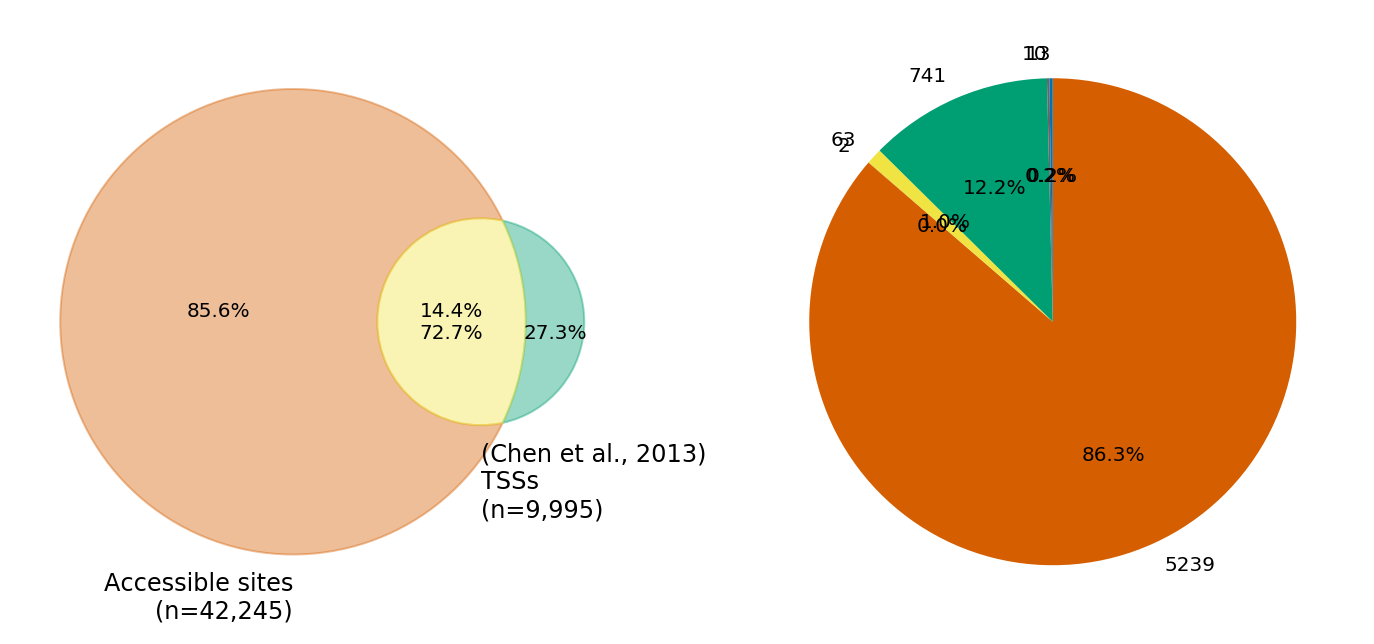

In [44]:
df_regl_ = regl_Apr27(flank_len=150)[['chrom', 'start', 'end', 'annot']]
#df_regl_['annot'] = regl_()['annot']

# (Chen et al., 2013)
gv = yp.GenomicVenn2(
    BedTool.from_dataframe(df_regl_),
    BedTool.from_dataframe(df_chen[yp.NAMES_BED3]),
    label_a='Accessible sites',
    label_b='(Chen et al., 2013)\nTSSs',
)

plt.figure(figsize=(12,6)).subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
v = gv.plot(style='compact')
v.get_patch_by_id('10').set_color(yp.RED)
v.get_patch_by_id('01').set_color(yp.GREEN)
v.get_patch_by_id('11').set_color(yp.YELLOW)

plt.subplot(1,2,2)
annot_count_ = gv.df_a_with_b['name'].value_counts()[config['annot']]
annot_count_.index = [
    'coding_promoter',
    'pseudogene_promoter',
    'unknown_promoter',
    'putative_enhancer',
    'non-coding_RNA',
    'other_element'
]
#plt.title('Annotation of %d accessible sites that overlap a TSS from (Chen et al., 2013)' % (len(gv.df_a_with_b),))
(patches, texts, autotexts) = plt.pie(
    annot_count_.values,
    #labels = ['%s (%d)' % (l, c) for l, c in annot_count_.iteritems()],
    labels = ['%d' % (c,) for l, c in annot_count_.iteritems()],
    colors=[yp.RED, yp.ORANGE, yp.YELLOW, yp.GREEN, '0.4', yp.BLUE],
    counterclock=False,
    startangle=90,
    autopct='%.1f%%',
    #explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
);
plt.gca().set_aspect('equal')
plt.savefig(vp('Chen2013_annot.pdf'), bbox_inches='tight', transparent=True)

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


13054 of 42245 sites with CV values via promoter annotation
26764 of 42245 sites with CV values via "associated gene"


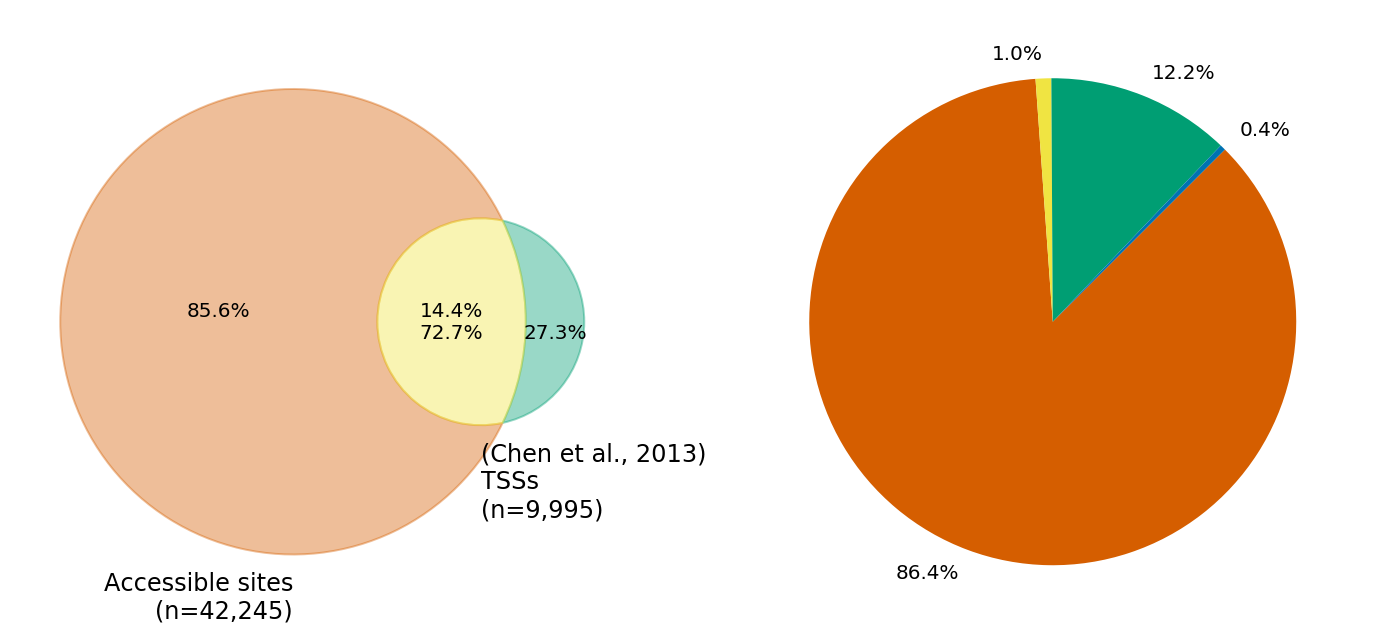

In [79]:
df_regl_ = regl_Apr27(flank_len=150)[['chrom', 'start', 'end', 'annot']]
#df_regl_['annot'] = regl_()['annot']

# (Chen et al., 2013)
gv = yp.GenomicVenn2(
    BedTool.from_dataframe(df_regl_),
    BedTool.from_dataframe(df_chen[yp.NAMES_BED3]),
    label_a='Accessible sites',
    label_b='(Chen et al., 2013)\nTSSs',
)

plt.figure(figsize=(12,6)).subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
v = gv.plot(style='compact')
v.get_patch_by_id('10').set_color(yp.RED)
v.get_patch_by_id('01').set_color(yp.GREEN)
v.get_patch_by_id('11').set_color(yp.YELLOW)

plt.subplot(1,2,2)
d_reduced_ = collections.OrderedDict([
    ('coding_promoter', 'coding_promoter, pseudogene_promoter'),
    ('pseudogene_promoter', 'coding_promoter, pseudogene_promoter'),
    ('unknown_promoter', 'unknown_promoter'),
    ('putative_enhancer', 'putative_enhancer'),
    ('non-coding_RNA', 'other_element, non-coding_RNA'),
    ('other_element', 'other_element, non-coding_RNA'),
])

d_colour_ = collections.OrderedDict([
    ('coding_promoter, pseudogene_promoter', yp.RED),
    ('unknown_promoter', yp.YELLOW),
    ('putative_enhancer', yp.GREEN),
    ('other_element, non-coding_RNA', yp.BLUE),
])

gv.df_a_with_b['name_reduced'] = [*map(lambda a: d_reduced_[a], gv.df_a_with_b['name'])]
annot_count_ = gv.df_a_with_b['name_reduced'].value_counts()[d_colour_.keys()]

#plt.title('Annotation of %d accessible sites that overlap a TSS from (Chen et al., 2013)' % (len(gv.df_a_with_b),))
(patches, texts) = plt.pie(
    annot_count_.values,
    labels = yp.pct_(annot_count_.values),
    colors=d_colour_.values(),
    counterclock=False,
    startangle=45,
);
plt.gca().set_aspect('equal')
#plt.savefig(vp('Chen2013_annot.pdf'), bbox_inches='tight', transparent=True)
plt.savefig('annot_Apr27/Fig2S3A_Chen2013_annot.pdf', bbox_inches='tight', transparent=True)

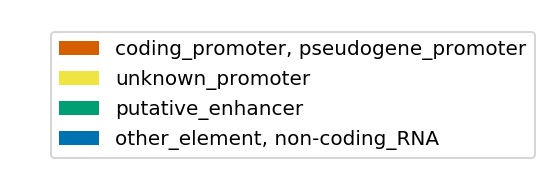

In [80]:
plt.figure(figsize=(0.2,0.2))
plt.gca().axis('off')
plt.gca().legend(patches, annot_count_.index, loc='upper left')
#plt.savefig(vp('Chen2013_annot_legend.pdf'), bbox_inches='tight', transparent=True)
plt.savefig('annot_Apr27/Fig2S3A_Chen2013_legend.pdf', bbox_inches='tight', transparent=True)

In [ ]:
# (Chen et al., 2013) TSSs now annotated as putative_enhancer
#fp_ = 'annot/FigC_TSS/overlaps_Chen2013_TSS_to_putative_enhancer.bed'
#gv.df_a_with_b.query('name == "putative_enhancer"').to_csv(fp_, header=False, sep='\t', index=False)
#!wc -l {fp_}